# KMeans: Scitkit, Pilot and Spark/MLlib


This is perhaps the best known database to be found in the pattern recognition literature. The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant (see <https://archive.ics.uci.edu/ml/datasets/Iris>). 

Source: R. A. Fisher, The Use of Multiple Measurements in Taxonomic Problems, 1936, http://rcs.chemometrics.ru/Tutorials/classification/Fisher.pdf

Pictures (Source [Wikipedia](https://en.wikipedia.org/wiki/Iris_flower_data_set))

<table>
<tr><td>
Setosa
</td><td>
Versicolor
</td><td>
Virginica
</td></tr>
<tr><td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/Kosaciec_szczecinkowaty_Iris_setosa.jpg/180px-Kosaciec_szczecinkowaty_Iris_setosa.jpg"/> 
</td><td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/41/Iris_versicolor_3.jpg/320px-Iris_versicolor_3.jpg"/>
</td><td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Iris_virginica.jpg/295px-Iris_virginica.jpg"/>
</td></tr></table>

## 1. Data Overview

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/pydata/pandas/master/pandas/tests/data/iris.csv")
data.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Name
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## 2. Scikit

In [7]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
results = kmeans.fit_predict(data[['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']])

In [8]:
data_kmeans=pd.concat([data, pd.Series(results, name="ClusterId")], axis=1)
data_kmeans.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Name,ClusterId
0,5.1,3.5,1.4,0.2,Iris-setosa,1
1,4.9,3.0,1.4,0.2,Iris-setosa,1
2,4.7,3.2,1.3,0.2,Iris-setosa,1
3,4.6,3.1,1.5,0.2,Iris-setosa,1
4,5.0,3.6,1.4,0.2,Iris-setosa,1


In the following we evaluate the model using the sum of squared error and a pair plot. The following pairplots show the scatter-plot between each of the four features. Clusters for the different species are indicated by the color.

In [9]:
print "Sum of squared error: %.1f"%kmeans.inertia_

Sum of squared error: 78.9


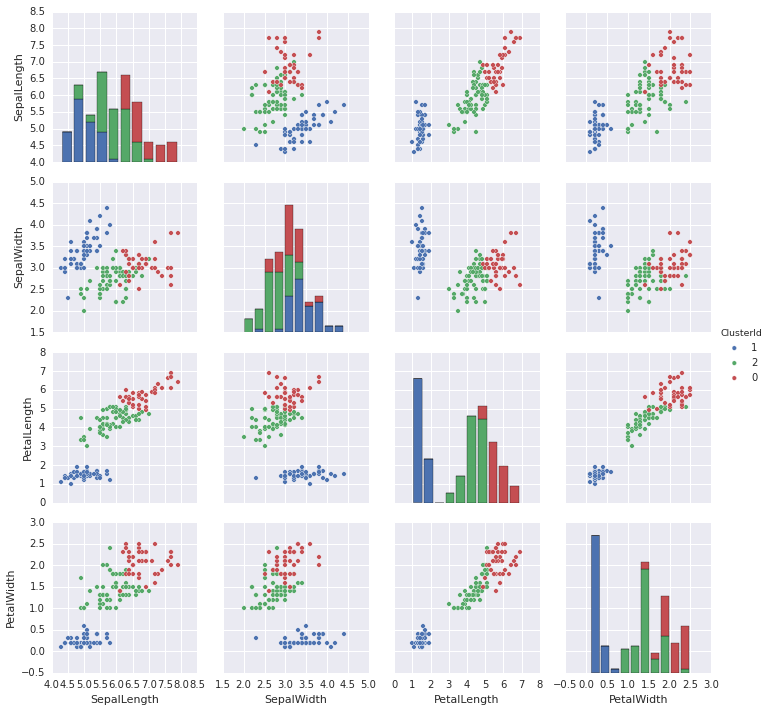

In [11]:
sns.pairplot(data_kmeans, vars=["SepalLength", "SepalWidth", "PetalLength", "PetalWidth"], hue="ClusterId");

## 3. Pilot Approach

In [3]:
import os, sys
import commands
import radical.pilot as rp
os.environ["RADICAL_PILOT_DBURL"]="mongodb://ec2-54-221-194-147.compute-1.amazonaws.com:24242/giannis"

def print_details(detail_object):
    if type(detail_object)==str:
        detail_object = ast.literal_eval(detail_object)
    for i in detail_object:
        detail_object[i]=str(detail_object[i])
    #print str(detail_object)
    return pd.DataFrame(detail_object.values(), 
             index=detail_object.keys(), 
             columns=["Value"])


session = rp.Session()
c = rp.Context('ssh')
c.user_id = "radical"
session.add_context(c)
pmgr = rp.PilotManager(session=session)
umgr = rp.UnitManager (session=session,
                       scheduler=rp.SCHED_DIRECT_SUBMISSION)
print "Session id: %s Pilot Manager: %s" % (session.uid, str(pmgr.as_dict()))
pdesc = rp.ComputePilotDescription ()
pdesc.resource = "local.localhost_anaconda"
pdesc.runtime  = 10 
pdesc.cores    = 16
pdesc.cleanup  = False
pilot = pmgr.submit_pilots(pdesc)
umgr = rp.UnitManager (session=session,
                       scheduler=rp.SCHED_DIRECT_SUBMISSION)
umgr.add_pilots(pilot)

Session id: rp.session.ip-10-99-194-113.radical.016747.0012 Pilot Manager: {'uid': 'pmgr.0000'}


Partition data and distribute to a set of CUs for fast processing

In [4]:
number_clusters = 3
clusters = data.sample(number_clusters)

In [5]:
clusters

,SepalLength,SepalWidth,PetalLength,PetalWidth,Name
62,6.0,2.2,4.0,1.0,Iris-versicolor
59,5.2,2.7,3.9,1.4,Iris-versicolor
87,6.3,2.3,4.4,1.3,Iris-versicolor


In [7]:
clusters.to_csv("clusters.csv")
data.to_csv("points.csv")

Helper Function for computing new centroids as mean of all points assigned to a cluster

In [8]:
def compute_new_centroids(distances):
    df = pd.DataFrame(distances)
    #print df
    df[4] =  df[4].astype(int)
    df = df.groupby(4)[0,1,2,3].mean()
    centroids_np = df.as_matrix()
    return centroids_np

### Running Mapper Function as External Process

In [122]:
for i in range(10):
    distances =!/opt/anaconda/bin/python mapper.py points.csv clusters.csv
    distances_np =  np.array(eval(" ".join(distances)))
    new_centroids = compute_new_centroids(distances_np)
    new_centroids_df = pd.DataFrame(new_centroids, columns=["SepalLength", "SepalWidth", "PetalLength", "PetalWidth"])
    new_centroids_df.to_csv("clusters.csv")        

### Running Mapper Function inside Radical-Pilot

Helper function to read output form completed compute units

In [9]:
import urlparse

def get_output(compute_unit):
    working_directory=compute_unit.as_dict()['working_directory']
    path = urlparse.urlparse(working_directory).path
    output=open(os.path.join(path, "STDOUT")).read()
    return output

In [15]:
for i in range(10):
    cudesc = rp.ComputeUnitDescription()
    cudesc.executable  = "/opt/anaconda/bin/python"
    cudesc.arguments   = [os.path.join(os.getcwd(), "mapper.py"),
                          os.path.join(os.getcwd(), "points.csv"),
                          os.path.join(os.getcwd(), "clusters.csv")]
    cu_set = umgr.submit_units([cudesc])
    umgr.wait_units()
    output = get_output(cu_set[0])
    distances_np =  np.array(eval(output))
    new_centroids = compute_new_centroids(distances_np)
    new_centroids_df = pd.DataFrame(new_centroids, columns=["SepalLength", "SepalWidth", "PetalLength", "PetalWidth"])
    new_centroids_df.to_csv("clusters.csv")        
    print "Finished iteration: %d"%(i)

Open: /home/radical/radical.pilot.sandbox/rp.session.ip-10-99-194-113.radical.016747.0012-pilot.0000//unit.000001
Open: /home/radical/radical.pilot.sandbox/rp.session.ip-10-99-194-113.radical.016747.0012-pilot.0000//unit.000002
Open: /home/radical/radical.pilot.sandbox/rp.session.ip-10-99-194-113.radical.016747.0012-pilot.0000//unit.000003
Open: /home/radical/radical.pilot.sandbox/rp.session.ip-10-99-194-113.radical.016747.0012-pilot.0000//unit.000004
Open: /home/radical/radical.pilot.sandbox/rp.session.ip-10-99-194-113.radical.016747.0012-pilot.0000//unit.000005
Open: /home/radical/radical.pilot.sandbox/rp.session.ip-10-99-194-113.radical.016747.0012-pilot.0000//unit.000006
Open: /home/radical/radical.pilot.sandbox/rp.session.ip-10-99-194-113.radical.016747.0012-pilot.0000//unit.000007
Open: /home/radical/radical.pilot.sandbox/rp.session.ip-10-99-194-113.radical.016747.0012-pilot.0000//unit.000008
Open: /home/radical/radical.pilot.sandbox/rp.session.ip-10-99-194-113.radical.016747.001

### Print out final centroids computed

In [17]:
new_centroids_df

,SepalLength,SepalWidth,PetalLength,PetalWidth
0,5.006000,3.418000,1.464000,0.244000
1,5.901613,2.748387,4.393548,1.433871
2,6.850000,3.073684,5.742105,2.071053


In [18]:
session.close()

## Spark MLLib

In [19]:
from numpy import array
from math import sqrt

%run ../env.py
%run ../util/init_spark.py

from pilot_hadoop import PilotComputeService as PilotSparkComputeService

pilotcompute_description = {
    "service_url": "yarn-client://sc15.radical-cybertools.org",
    "number_of_processes": 5
}
pilot_spark = PilotSparkComputeService.create_pilot(pilotcompute_description=pilotcompute_description)
sc = pilot_spark.get_spark_context()
sqlCtx=SQLContext(sc)

In [20]:
# Load and parse the data
data_spark=sqlCtx.createDataFrame(data)
data_spark_without_class=data_spark.select('SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth').show()

Py4JJavaError: An error occurred while calling o59.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 0.0 failed 4 times, most recent failure: Lost task 0.3 in stage 0.0 (TID 3, ip-10-218-164-206.ec2.internal): java.io.IOException: Cannot run program "/opt/anaconda/envs/python2/bin/python": error=2, No such file or directory
	at java.lang.ProcessBuilder.start(ProcessBuilder.java:1047)
	at org.apache.spark.api.python.PythonWorkerFactory.startDaemon(PythonWorkerFactory.scala:160)
	at org.apache.spark.api.python.PythonWorkerFactory.createThroughDaemon(PythonWorkerFactory.scala:86)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:62)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:135)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:101)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:297)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:264)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:297)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:264)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:297)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:264)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:297)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:264)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:297)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:264)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:297)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:264)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:297)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:264)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:66)
	at org.apache.spark.scheduler.Task.run(Task.scala:88)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:214)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1145)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:615)
	at java.lang.Thread.run(Thread.java:745)
Caused by: java.io.IOException: error=2, No such file or directory
	at java.lang.UNIXProcess.forkAndExec(Native Method)
	at java.lang.UNIXProcess.<init>(UNIXProcess.java:186)
	at java.lang.ProcessImpl.start(ProcessImpl.java:130)
	at java.lang.ProcessBuilder.start(ProcessBuilder.java:1028)
	... 32 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1283)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1271)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1270)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1270)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:697)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:697)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:697)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1496)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1458)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1447)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:567)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1822)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1835)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1848)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:215)
	at org.apache.spark.sql.execution.Limit.executeCollect(basicOperators.scala:207)
	at org.apache.spark.sql.DataFrame$$anonfun$collect$1.apply(DataFrame.scala:1385)
	at org.apache.spark.sql.DataFrame$$anonfun$collect$1.apply(DataFrame.scala:1385)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:56)
	at org.apache.spark.sql.DataFrame.withNewExecutionId(DataFrame.scala:1903)
	at org.apache.spark.sql.DataFrame.collect(DataFrame.scala:1384)
	at org.apache.spark.sql.DataFrame.head(DataFrame.scala:1314)
	at org.apache.spark.sql.DataFrame.take(DataFrame.scala:1377)
	at org.apache.spark.sql.DataFrame.showString(DataFrame.scala:178)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:57)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:606)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.lang.Thread.run(Thread.java:745)
Caused by: java.io.IOException: Cannot run program "/opt/anaconda/envs/python2/bin/python": error=2, No such file or directory
	at java.lang.ProcessBuilder.start(ProcessBuilder.java:1047)
	at org.apache.spark.api.python.PythonWorkerFactory.startDaemon(PythonWorkerFactory.scala:160)
	at org.apache.spark.api.python.PythonWorkerFactory.createThroughDaemon(PythonWorkerFactory.scala:86)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:62)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:135)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:101)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:297)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:264)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:297)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:264)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:297)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:264)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:297)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:264)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:297)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:264)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:297)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:264)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:297)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:264)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:66)
	at org.apache.spark.scheduler.Task.run(Task.scala:88)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:214)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1145)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:615)
	... 1 more
Caused by: java.io.IOException: error=2, No such file or directory
	at java.lang.UNIXProcess.forkAndExec(Native Method)
	at java.lang.UNIXProcess.<init>(UNIXProcess.java:186)
	at java.lang.ProcessImpl.start(ProcessImpl.java:130)
	at java.lang.ProcessBuilder.start(ProcessBuilder.java:1028)
	... 32 more


### Convert DataFrame to Tuple for MLlib

In [ ]:
data_spark_tuple = data_spark.map(lambda a: (a[0],a[1],a[2],a[3]))

In [ ]:
from pyspark.mllib.clustering import KMeans, KMeansModel
clusters = KMeans.train(data_spark_tuple, 3, maxIterations=10,
                        runs=10, initializationMode="random")

In [ ]:
# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = data_spark_tuple.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))
